In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import re

In [93]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [95]:
# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinamratha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [97]:
train = pd.read_csv('train_data.txt', sep=' ::: ', engine='python', header=None, names=['id', 'title', 'genre', 'synopsis'])

test = pd.read_csv('test_data.txt', sep='\t', header=None, names=['synopsis'])

In [98]:
train.head()

,id,title,genre,synopsis
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [99]:
train.tail()

,id,title,genre,synopsis
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...
54213,54214,Nature's Fury: Storm of the Century (2006),history,"On Labor Day Weekend, 1935, the most intense h..."


In [103]:
test.head()

,synopsis
0,1 ::: Edgar's Lunch (1998) ::: L.R. Brane love...
1,"2 ::: La guerra de papá (1977) ::: Spain, Marc..."
2,3 ::: Off the Beaten Track (2010) ::: One year...
3,4 ::: Meu Amigo Hindu (2015) ::: His father ha...
4,5 ::: Er nu zhai (1955) ::: Before he was know...


In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        54214 non-null  int64 
 1   title     54214 non-null  object
 2   genre     54214 non-null  object
 3   synopsis  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [107]:
# Drop NaN values
train.dropna(subset=['genre', 'synopsis'], inplace=True)
test.dropna(subset=['synopsis'], inplace=True)

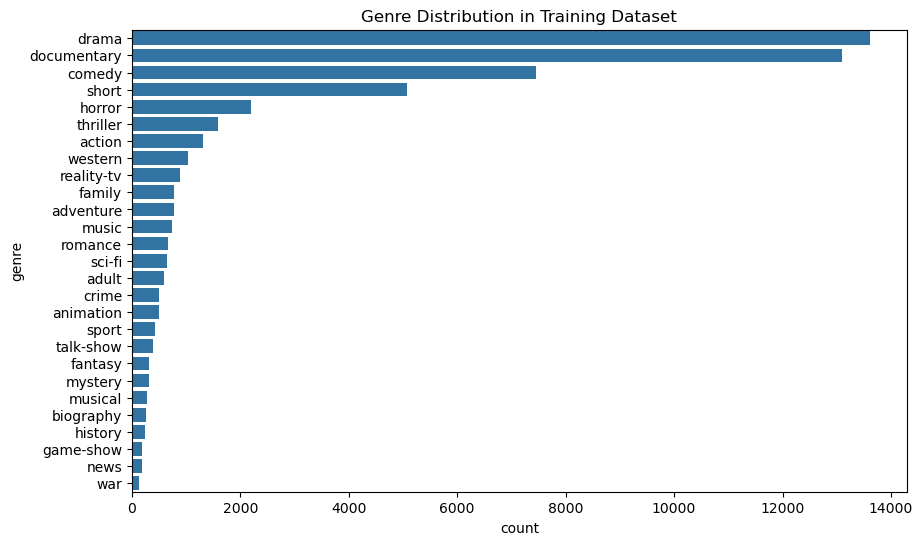

In [109]:
# Display genre distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=train['genre'], order=train['genre'].value_counts().index)
plt.title("Genre Distribution in Training Dataset")
plt.show()

In [111]:
# Function to clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", '', text) # Keep only letters
    text = text.lower() # Lowercase text
    text = text.strip() # Remove leading/trailing whitespaces
    return text

In [113]:
# Apply text cleaning
train['plot'] = train['synopsis'].apply(clean_text)
test['plot'] = test['synopsis'].apply(clean_text)

In [115]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

train['plot'] = train['plot'].apply(remove_stopwords)
test['plot'] = test['plot'].apply(remove_stopwords)

In [117]:
# Stemming
stemmer = PorterStemmer()
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

train['plot'] = train['plot'].apply(stem_text)
test['plot'] = test['plot'].apply(stem_text)

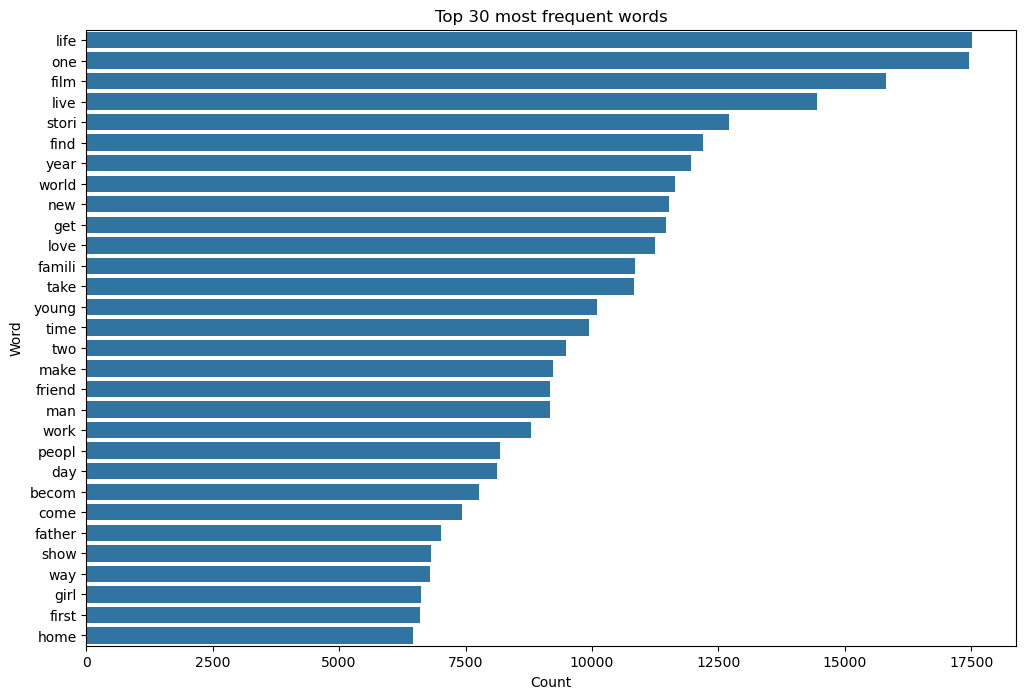

In [119]:
# Visualize most frequent words in train dataset
def plot_freq_words(text, top_n=30):
    all_words = ' '.join(text).split()
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame(freq_dist.most_common(top_n), columns=['Word', 'Count'])
    plt.figure(figsize=(12,8))
    sns.barplot(x='Count', y='Word', data=words_df)
    plt.title(f'Top {top_n} most frequent words')
    plt.show()

plot_freq_words(train['plot'], 30)

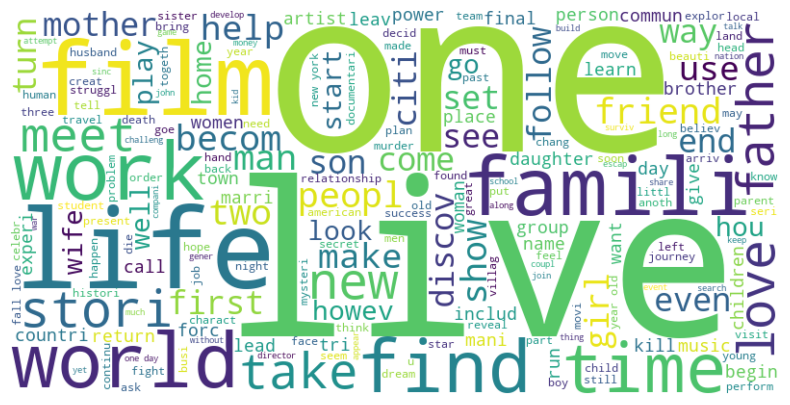

In [120]:
# Generate WordCloud for visualization
def generate_wordcloud(text):
    all_words = ' '.join(text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_wordcloud(train['plot'])

In [123]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) # Using bigrams for better context
X_train = tfidf_vectorizer.fit_transform(train['plot'])
X_test = tfidf_vectorizer.transform(test['plot'])
y_train = train['genre']

In [124]:
# Split data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [127]:
# Classifier - Naive Bayes
nb_classifier = MultinomialNB()

In [129]:
# Hyperparameter tuning using GridSearchCV
param_grid = {'alpha': [0.1, 0.5, 1.0]}
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5)
grid_search.fit(X_train_split, y_train_split)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]})

In [131]:
# Get best parameters
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'alpha': 0.1}


In [133]:
# Predict on validation set
y_val_pred = best_model.predict(X_val)

In [135]:
# Evaluation - Accuracy, Classification Report, Confusion Matrix
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 54.65%
              precision    recall  f1-score   support

      action       0.47      0.21      0.28       263
       adult       0.55      0.19      0.29       118
   adventure       0.65      0.08      0.15       155
   animation       0.67      0.04      0.08       100
   biography       0.00      0.00      0.00        53
      comedy       0.52      0.46      0.49      1490
       crime       0.50      0.01      0.02       101
 documentary       0.59      0.87      0.71      2619
       drama       0.48      0.79      0.60      2723
      family       0.83      0.06      0.12       157
     fantasy       0.50      0.02      0.03        65
   game-show       1.00      0.54      0.70        39
     history       0.00      0.00      0.00        49
      horror       0.75      0.48      0.58       441
       music       0.63      0.36      0.46       146
     musical       0.00      0.00      0.00        55
     mystery       0.00      0.00      0.00        64

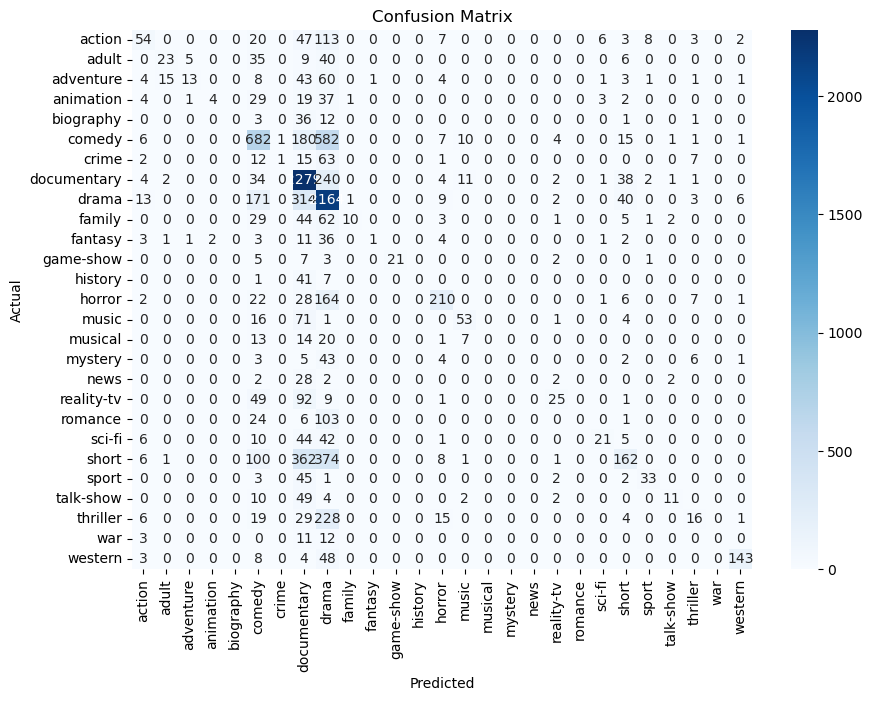

In [137]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [139]:
# Predict on test data
y_test_pred = best_model.predict(X_test)

In [141]:
# Save the predictions
test['Predicted Genre'] = y_test_pred
test.to_csv('predicted_genres.csv', index=False)
print("SUCCESSFULLY PREDICTED THE GENRE OF THE MOVIE FROM THE SUMMARY PLOT")

SUCCESSFULLY PREDICTED THE GENRE OF THE MOVIE FROM THE SUMMARY PLOT
